In [5]:
import numpy as np
import tensorflow as tf

def load_synthetic_data2d():
    # Generate a sequence of 2D positions with constant acceleration and added noise
    def generate_linear_trajectory(length, x_start, y_start, ax, ay, noise_std):
        x, y = x_start, y_start
        vx, vy = 0, 0
        trajectory = [(x, y)]
        for _ in range(length - 1):
            vx += ax
            vy += ay
            x += vx + np.random.normal(0, noise_std)
            y += vy + np.random.normal(0, noise_std)
            trajectory.append((x, y))
        return trajectory

    # Generate a sequence of 2D positions representing a circular trajectory with added noise
    def generate_circular_trajectory(length, radius, cx, cy, angular_velocity, noise_std):
        trajectory = []
        for t in range(length):
            angle = angular_velocity * t
            x = cx + radius * np.cos(angle) + np.random.normal(0, noise_std)
            y = cy + radius * np.sin(angle) + np.random.normal(0, noise_std)
            trajectory.append((x, y))
        return trajectory

    # Prepare data for the LSTM
    def get_dataset(seq_len, n_samples, noise_std=0.1):
        traj = list()
        for _ in range(n_samples):
            # Randomly choose between linear or circular trajectory
            if np.random.rand() < 0.5:
                # Generate linear trajectory
                x_start, y_start = np.random.uniform(0, 100), np.random.uniform(0, 100)
                ax, ay = np.random.uniform(-1, 1), np.random.uniform(-1, 1)
                source = generate_linear_trajectory(seq_len, x_start, y_start, ax, ay, noise_std)
            else:
                # Generate circular trajectory
                radius = np.random.uniform(5, 20)
                cx, cy = np.random.uniform(20, 60), np.random.uniform(20, 60)
                angular_velocity = np.random.uniform(0.1, 0.3)
                source = generate_circular_trajectory(seq_len, radius, cx, cy, angular_velocity, noise_std)

            traj.append(source)
        return traj

    ds_pos = get_dataset(15, 640000)
    ds_pose = np.ones((640000,15,51))

    pos_dataset = tf.data.Dataset.from_tensor_slices(np.asarray(ds_pos))
    pose_dataset = tf.data.Dataset.from_tensor_slices(np.asarray(ds_pose))
    zip_ds = tf.data.Dataset.zip((pos_dataset, pose_dataset))
    zip_ds = zip_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    zip_ds = zip_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE) 

    # Shuffle, batch and split dataset
    DATASET_SIZE = len(zip_ds)

    train_size = int(0.8 * DATASET_SIZE)
    test_size = int(0.2 * DATASET_SIZE)

    train_dataset = zip_ds.take(train_size)
    test_dataset = zip_ds.skip(train_size)

    return train_dataset, test_dataset

# Example usage
train_dataset, test_dataset = load_synthetic_data2d()


: 

In [6]:
ds2 = np.ones((320000,15,51))

In [7]:
import tensorflow as tf

In [8]:
pos_dataset = tf.data.Dataset.from_tensor_slices(np.asarray(ds))
pose_dataset = tf.data.Dataset.from_tensor_slices(np.asarray(ds2))
zip_ds = tf.data.Dataset.zip((pos_dataset, pose_dataset))
zip_ds = zip_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
zip_ds = zip_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE) 

# shuffle, batch and split dataset
DATASET_SIZE = len(zip_ds)

train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

train_dataset = zip_ds.take(train_size)
test_dataset = zip_ds.skip(train_size)

2024-08-07 12:41:54.374889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-07 12:41:54.419986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-07 12:41:54.420633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-07 12:41:54.422626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-07 12:41:54.423053: I tensorflow/compile

In [3]:
len(ds)

8000

In [4]:
tf.data.experimental.save(
    ds, path= "test_synthetic_2d"
)
tf.data.experimental.save(
    ds2, path= "train_synthetic_2d"
)

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


2024-08-07 16:17:12.315689: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1958400000 exceeds 10% of free system memory.
2024-08-07 16:17:13.962078: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1958400000 exceeds 10% of free system memory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Generate a sequence of 2D positions with constant acceleration
def generate_linear_trajectory(length, x_start, y_start, ax, ay):
    x, y = x_start, y_start
    vx, vy = 0, 0
    trajectory = [(x, y)]
    for _ in range(length - 1):
        vx += ax
        vy += ay
        x += vx
        y += vy
        trajectory.append((x, y))
    return trajectory

# Generate a sequence of 2D positions representing a circular trajectory
def generate_circular_trajectory(length, radius, cx, cy, angular_velocity):
    trajectory = []
    for t in range(length):
        angle = angular_velocity * t
        x = cx + radius * np.cos(angle)
        y = cy + radius * np.sin(angle)
        trajectory.append((x, y))
    return trajectory

# Prepare data for the LSTM
def get_dataset(history_steps, predict_steps, n_samples):
    X1, X2, y = list(), list(), list()
    for _ in range(n_samples):
        # Randomly choose between linear or circular trajectory
        if np.random.rand() < 0.5:
            # Generate linear trajectory
            x_start, y_start = np.random.uniform(0, 100), np.random.uniform(0, 100)
            ax, ay = np.random.uniform(-1, 1), np.random.uniform(-1, 1)
            source = generate_linear_trajectory(history_steps + predict_steps, x_start, y_start, ax, ay)
        else:
            # Generate circular trajectory
            radius = np.random.uniform(5, 20)
            cx, cy = np.random.uniform(20, 80), np.random.uniform(20, 80)
            angular_velocity = np.random.uniform(0.1, 0.5)
            source = generate_circular_trajectory(history_steps + predict_steps, radius, cx, cy, angular_velocity)

        # Define input sequence (first 5 steps)
        input_seq = source[:history_steps]
        # Define target sequence (next 10 steps)
        target = source[history_steps:]
        # Create input target sequence with a zeroed start
        target_in = [(0, 0)] + target[:-1]
        # Store
        X1.append(input_seq)
        X2.append(target_in)
        y.append(target)
    return array(X1), array(X2), array(y)

# Returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
    # Define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # Define training decoder
    decoder_inputs = Input(shape=(None, n_input))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output)
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # Define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # Define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

# Generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps):
    # Encode
    state = infenc.predict(source)
    # Start of sequence input
    target_seq = array([[0.0, 0.0]]).reshape(1, 1, 2)
    # Collect predictions
    output = list()
    for t in range(n_steps):
        # Predict next position
        yhat, h, c = infdec.predict([target_seq] + state)
        # Store prediction
        output.append(yhat[0,0,:])
        # Update state
        state = [h, c]
        # Update target sequence
        target_seq = yhat.reshape(1, 1, 2)
    return array(output)

# Plot the sequences
def plot_sequences(input_seq, true_seq, predicted_seq):
    fig, ax = plt.subplots(3, 1, figsize=(10, 8))
    
    ax[0].set_title("Input Sequence")
    ax[0].plot([pos[0] for pos in input_seq], [pos[1] for pos in input_seq], marker='o')
    
    ax[1].set_title("True Output Sequence")
    ax[1].plot([pos[0] for pos in true_seq], [pos[1] for pos in true_seq], marker='o')
    
    ax[2].set_title("Predicted Output Sequence")
    ax[2].plot([pos[0] for pos in predicted_seq], [pos[1] for pos in predicted_seq], marker='o')
    
    plt.tight_layout()
    plt.show()

# Configure problem
history_steps = 5
predict_steps = 10
n_features = 2

# Define model
train, infenc, infdec = define_models(n_features, n_features, 128)
train.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Generate training dataset
#X1, X2, y = get_dataset(history_steps, predict_steps, 50000)
#print(X1.shape, X2.shape, y.shape)

# Train model
#train.fit([X1, X2], y, epochs=20, batch_size=64)

# Spot check some examples
"""for _ in range(10):
    X1, X2, y = get_dataset(history_steps, predict_steps, 1)
    target = predict_sequence(infenc, infdec, X1, predict_steps)
    input_seq = X1[0]
    true_seq = y[0]
    predicted_seq = target
    print(f'Input Sequence: {input_seq}')
    print(f'True Output Sequence: {true_seq}')
    print(f'Predicted Output Sequence: {predicted_seq}')
    plot_sequences(input_seq, true_seq, predicted_seq)"""


"for _ in range(10):\n    X1, X2, y = get_dataset(history_steps, predict_steps, 1)\n    target = predict_sequence(infenc, infdec, X1, predict_steps)\n    input_seq = X1[0]\n    true_seq = y[0]\n    predicted_seq = target\n    print(f'Input Sequence: {input_seq}')\n    print(f'True Output Sequence: {true_seq}')\n    print(f'Predicted Output Sequence: {predicted_seq}')\n    plot_sequences(input_seq, true_seq, predicted_seq)"

In [41]:
train.save_weights('path_to_save_weights.h5')

In [4]:
import tensorflow as tf

In [5]:
%matplotlib inline

In [6]:
loaded = tf.data.experimental.load(
    "/home/annalena/PedestrianTrajectoryPrediction/datasets/train_dataset_synth"
)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6617629022331564282


In [10]:

# Prepare data for training
def prepare_data_2d(dataset, history_steps, predict_steps):
    X1_list, X2_list, y_list = [], [], []
    
    for batch_x1, _ in dataset:
        batch_x1 = batch_x1.numpy()  # Convert Tensor to NumPy array
        batch_size = batch_x1.shape[0]
        
        for i in range(batch_size):
            sequence = batch_x1[i]
            
            # Take only the first two dimensions (2D positions)
            sequence = sequence[:, :2]  # Ensure sequence has only 2 features
            
            if len(sequence) >= history_steps + predict_steps:
                input_seq = sequence[:history_steps]
                target_seq = sequence[history_steps:history_steps + predict_steps]
                
                # Create target_in (shifted target sequence with a zeroed start)
                target_in = np.zeros((predict_steps, 2))
                target_in[1:] = target_seq[:-1]  # Shift target sequence
                
                # Store sequences
                X1_list.append(input_seq)
                X2_list.append(target_in)
                y_list.append(target_seq)
    
    X1 = np.array(X1_list)
    X2 = np.array(X2_list)
    y = np.array(y_list)
    
    return X1, X2, y
history_steps = 8
predict_steps = 7
X1, X2, y = prepare_data_2d(loaded, history_steps, predict_steps)
X1 = X1[:100000]
X2 = X2[:100000]
y = y[:100000]
print(X1.shape, X2.shape,  y.shape)


from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X1_scaled = scaler.fit_transform(X1.reshape(-1, X1.shape[-1])).reshape(X1.shape)
y_scaled = scaler.transform(y.reshape(-1, y.shape[-1])).reshape(y.shape)
print(X1_scaled.shape, y_scaled.shape)

(100000, 8, 2) (100000, 7, 2) (100000, 7, 2)
(100000, 8, 2) (100000, 7, 2)


In [11]:
train, infenc, infdec = define_models(n_input=2, n_output=2, n_units=128)
#train.load_weights('path_to_save_weights.h5')
train.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Prepare decoder inputs as zero sequences of shape (batch_size, 1, n_features) for training
#decoder_inputs = np.zeros((X1.shape[0], 1, 2))  # Initialize decoder inputs with zeros

# Fine-tune the model on the prepared data
#train.fit([X1, decoder_inputs], y, epochs=15, batch_size=64)

train.fit([X1, X2], y, epochs=15, batch_size=64)

Epoch 1/15
1563/1563 [==============================] - 19s 11ms/step - loss: 19.2446
Epoch 2/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7870
Epoch 3/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.2213
Epoch 4/15
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0919
Epoch 5/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0506
Epoch 6/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0349
Epoch 7/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0279
Epoch 8/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0244
Epoch 9/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0225
Epoch 10/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0213
Epoch 11/15
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0207
Epoch 12/15
1563/1563 [==============================] - 16s 1

1/1 [==============================] - 0s 23ms/step


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 6617629022331564282


1/1 [==============================] - 0s 18ms/step


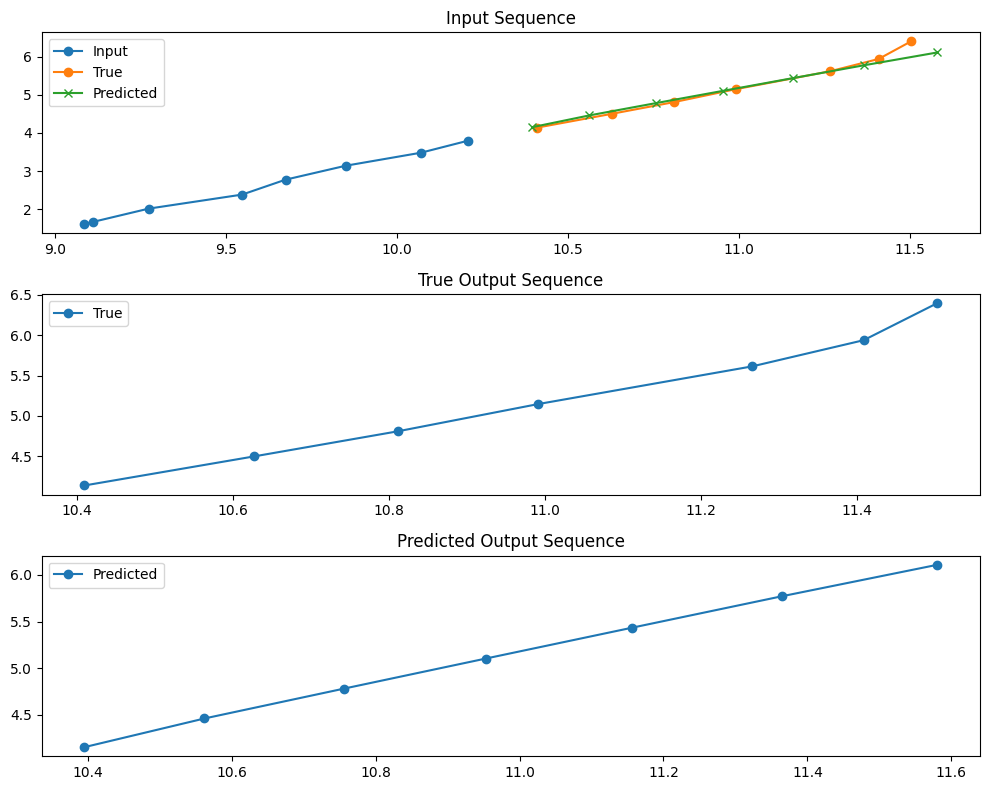

1/1 [==============================] - 0s 22ms/step


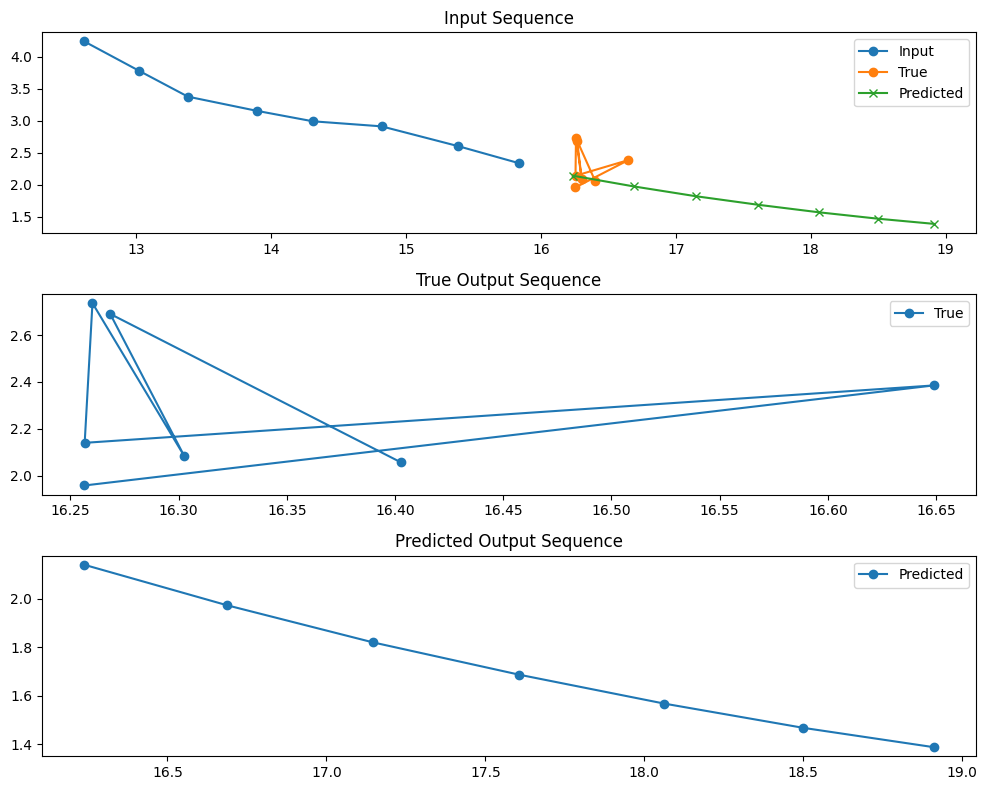

1/1 [==============================] - 0s 17ms/step


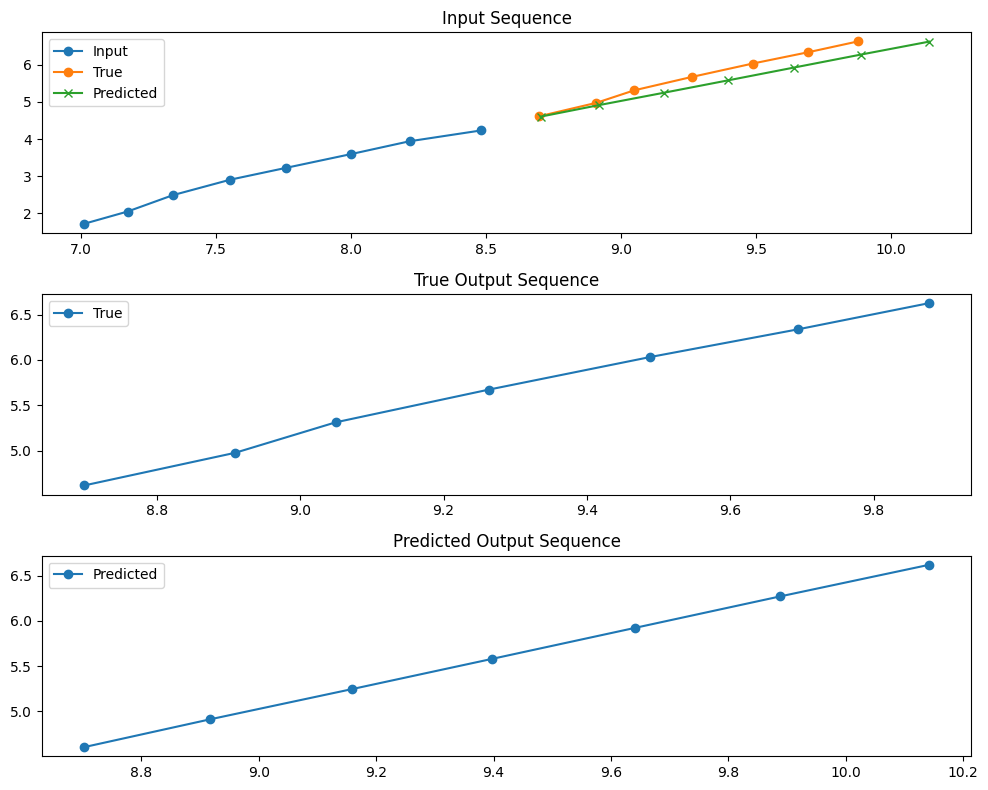

1/1 [==============================] - 0s 20ms/step


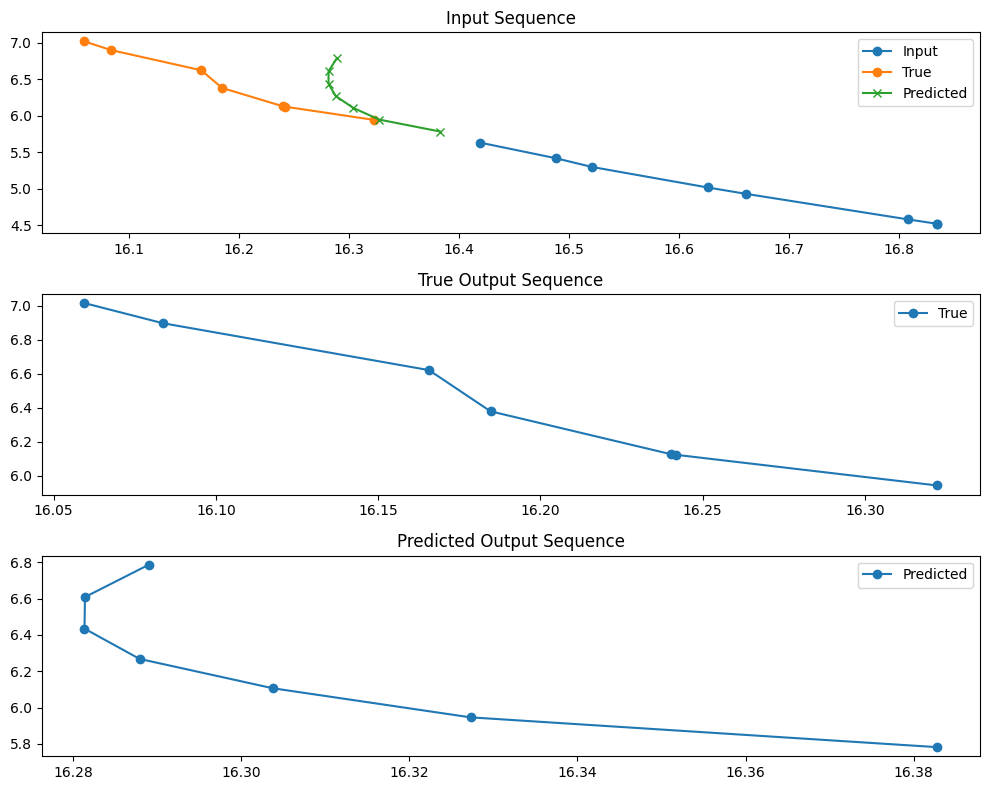

1/1 [==============================] - 0s 21ms/step


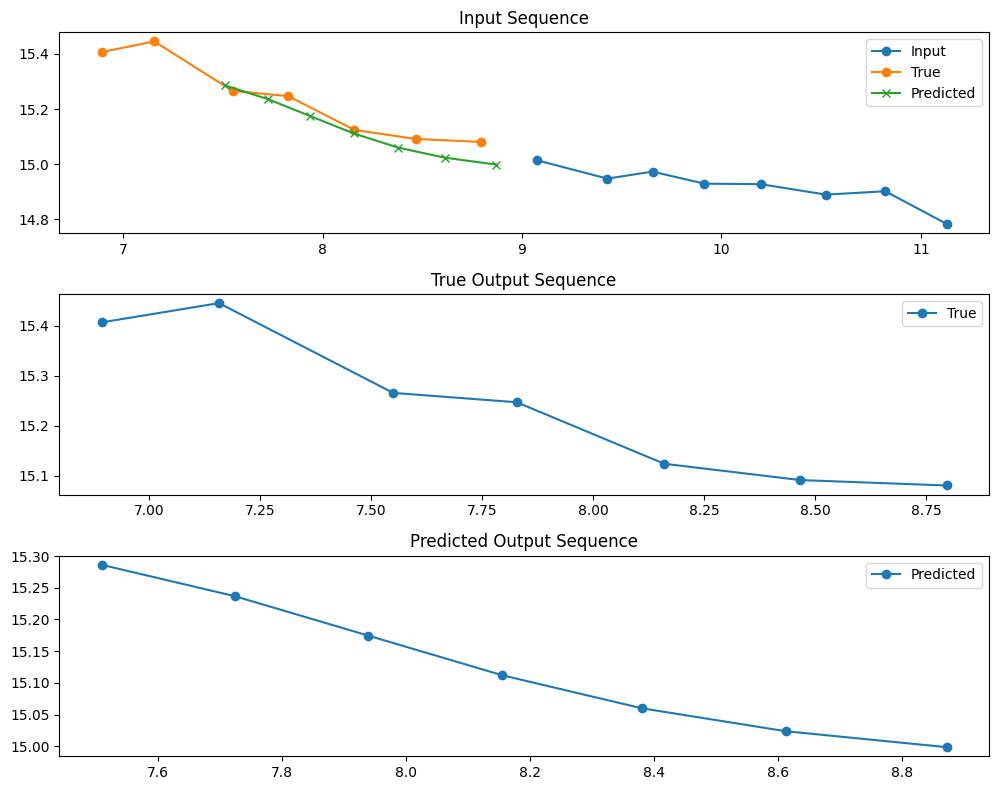

1/1 [==============================] - 0s 17ms/step


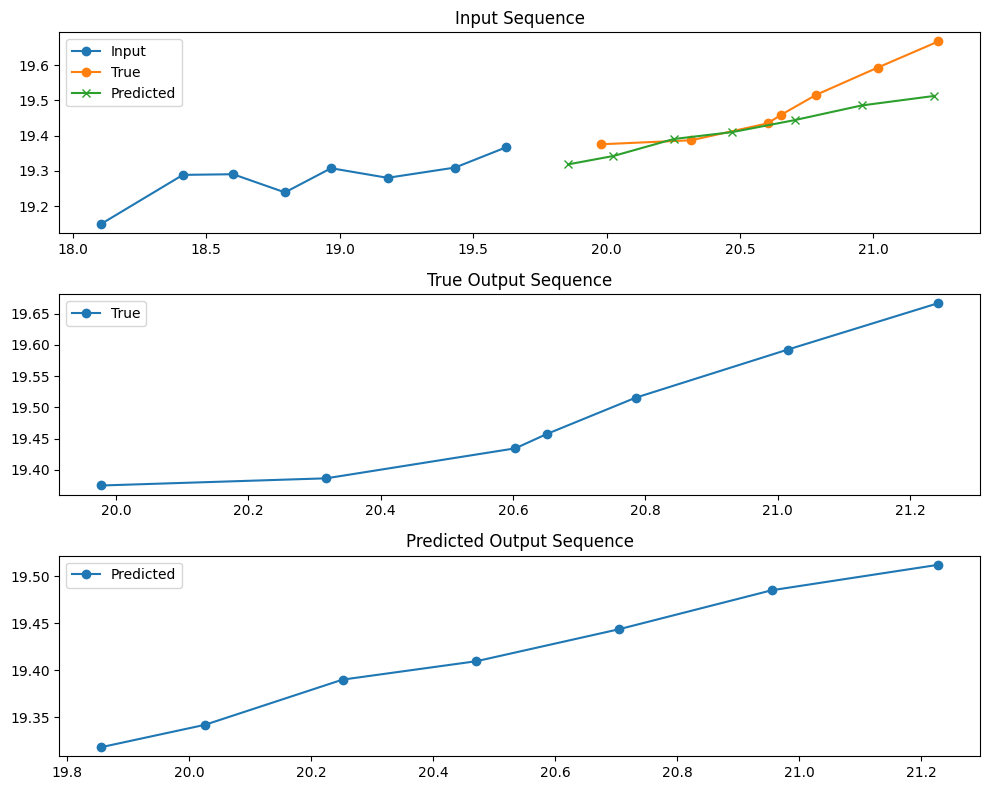

1/1 [==============================] - 0s 18ms/step


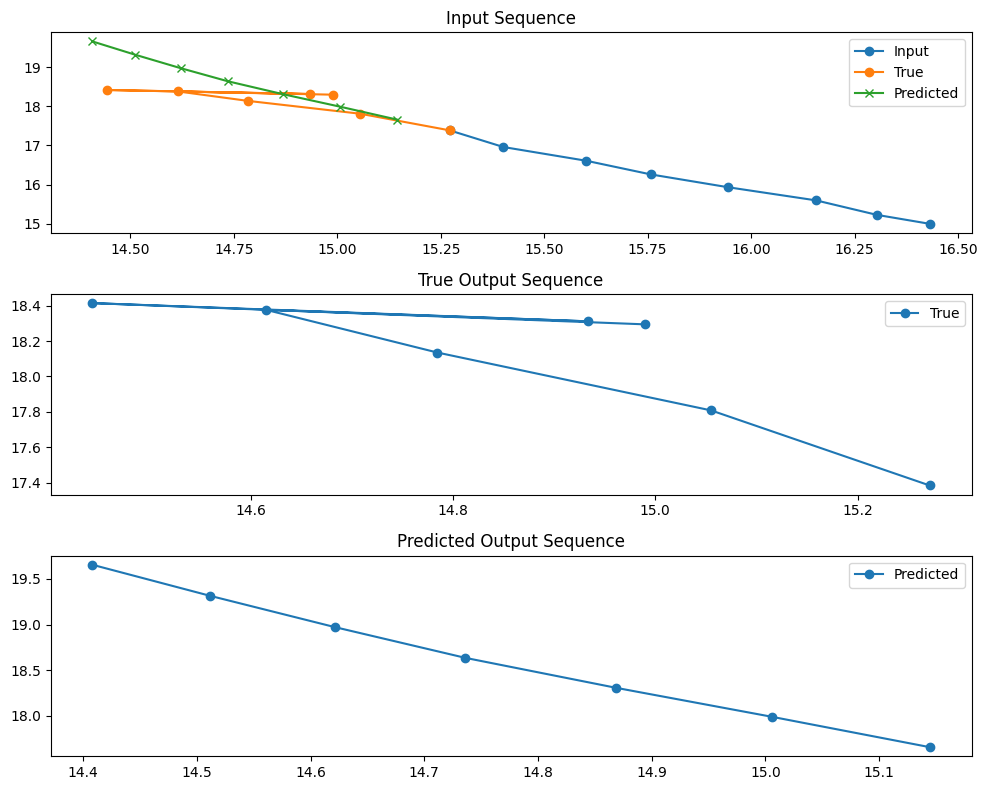

1/1 [==============================] - 0s 17ms/step


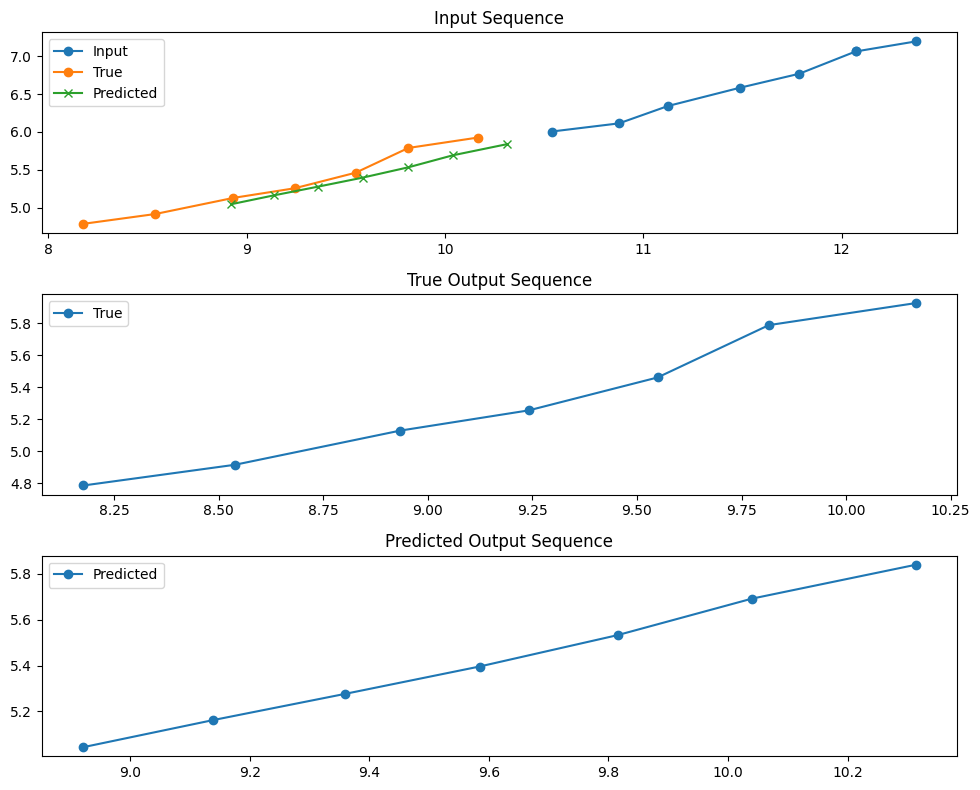

1/1 [==============================] - 0s 17ms/step


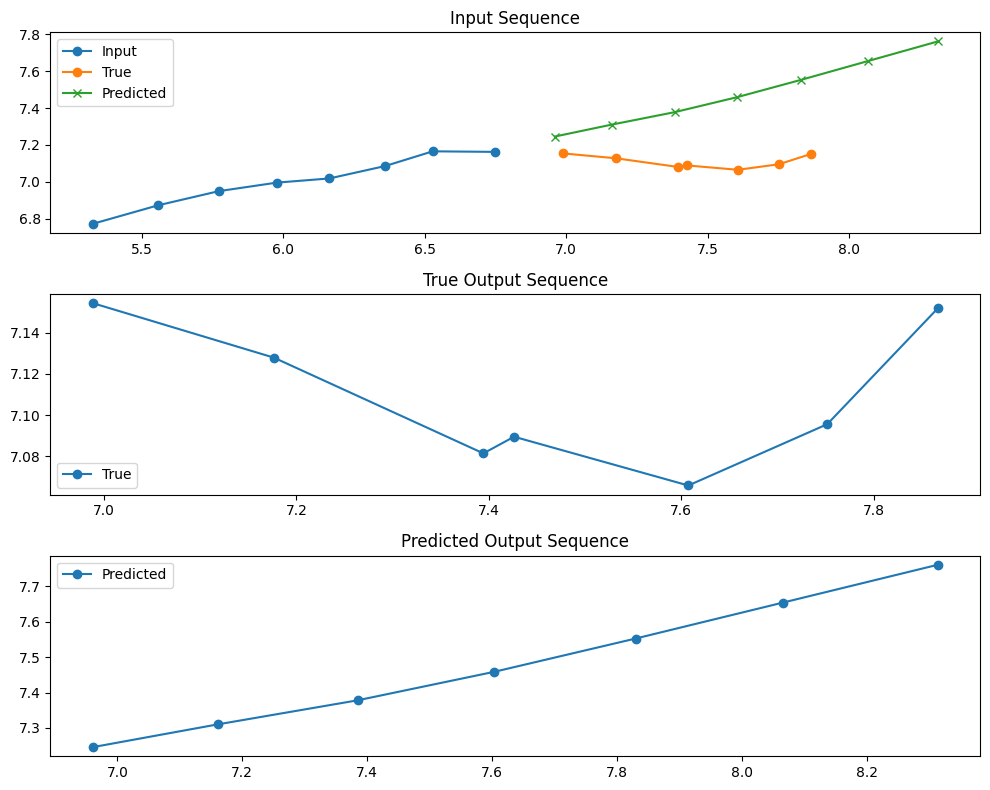

1/1 [==============================] - 0s 17ms/step


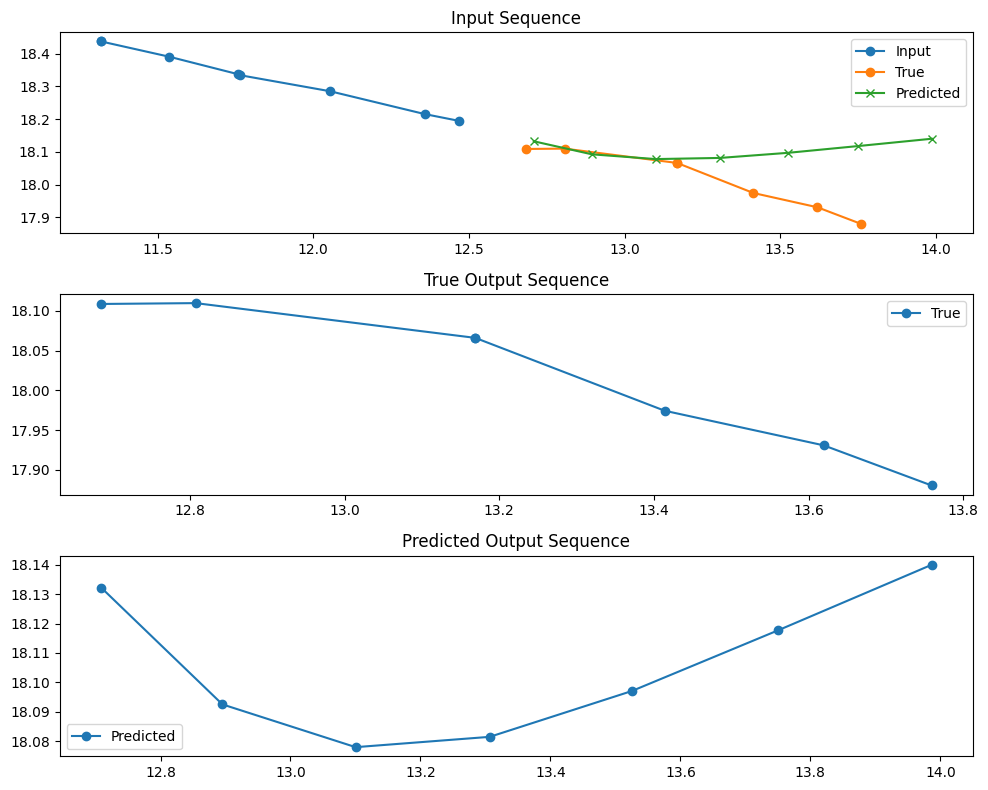

In [15]:
# Spot check some examples
for batch_x1, _ in loaded.take(1):
    batch_x1 = batch_x1.numpy()  # Convert Tensor to NumPy array
    for i in range(10):
        input_seq = batch_x1[i][:history_steps, :2]  # Ensure the input sequence has 2 features
        true_seq = batch_x1[i][history_steps:history_steps + predict_steps, :2]  # Ensure the true sequence has 2 features
        
        # Add an extra dimension to match the model's expected input shape
        input_seq_expanded = input_seq[np.newaxis, :, :]  # Shape should be (1, history_steps, 2)

        # Predicting sequence using the model
        predicted_seq = predict_sequence(infenc, infdec, input_seq_expanded, predict_steps)

        #print(f'Input Sequence:\n{input_seq}')
        #print(f'True Output Sequence:\n{true_seq}')
        #print(f'Predicted Output Sequence:\n{predicted_seq}')

        # Plot sequences
        def plot_sequences(input_seq, true_seq, predicted_seq):
            fig, ax = plt.subplots(3, 1, figsize=(10, 8))

            ax[0].set_title("Input Sequence")
            ax[0].plot(input_seq[:, 0], input_seq[:, 1], marker='o', label='Input')
            ax[0].plot(true_seq[:, 0], true_seq[:, 1], marker='o', label='True')
            ax[0].plot(predicted_seq[:, 0], predicted_seq[:, 1], marker='x', label='Predicted')
            ax[0].legend()

            ax[1].set_title("True Output Sequence")
            ax[1].plot(true_seq[:, 0], true_seq[:, 1], marker='o', label='True')
            ax[1].legend()

            ax[2].set_title("Predicted Output Sequence")
            ax[2].plot(predicted_seq[:, 0], predicted_seq[:, 1], marker='o', label='Predicted')
            ax[2].legend()

            plt.tight_layout()
            plt.show()

        plot_sequences(input_seq, true_seq, predicted_seq)

# Data Visualisation

In [44]:
# Prepare data for training
def prepare_data_2d(dataset, history_steps, predict_steps):
    X1_list, y_list = [], []
    for batch_x1, _ in dataset:
        batch_x1 = batch_x1.numpy()  # Convert Tensor to NumPy array
        batch_size = batch_x1.shape[0]
        for i in range(batch_size):
            sequence = batch_x1[i]
            
            # Take only the first two dimensions (2D positions)
            sequence = sequence[:, :2]  # Ensure sequence has only 2 features
            
            if len(sequence) >= history_steps + predict_steps:
                input_seq = sequence[:history_steps]
                target_seq = sequence[history_steps:history_steps + predict_steps]
                X1_list.append(input_seq)
                y_list.append(target_seq)
    
    X1 = np.array(X1_list)
    y = np.array(y_list)
    
    return X1, y

# Prepare the data
history_steps = 5
predict_steps = 10
X1, y = prepare_data_2d(loaded, history_steps, predict_steps)
print(X1.shape, y.shape)

(211456, 5, 2) (211456, 10, 2)


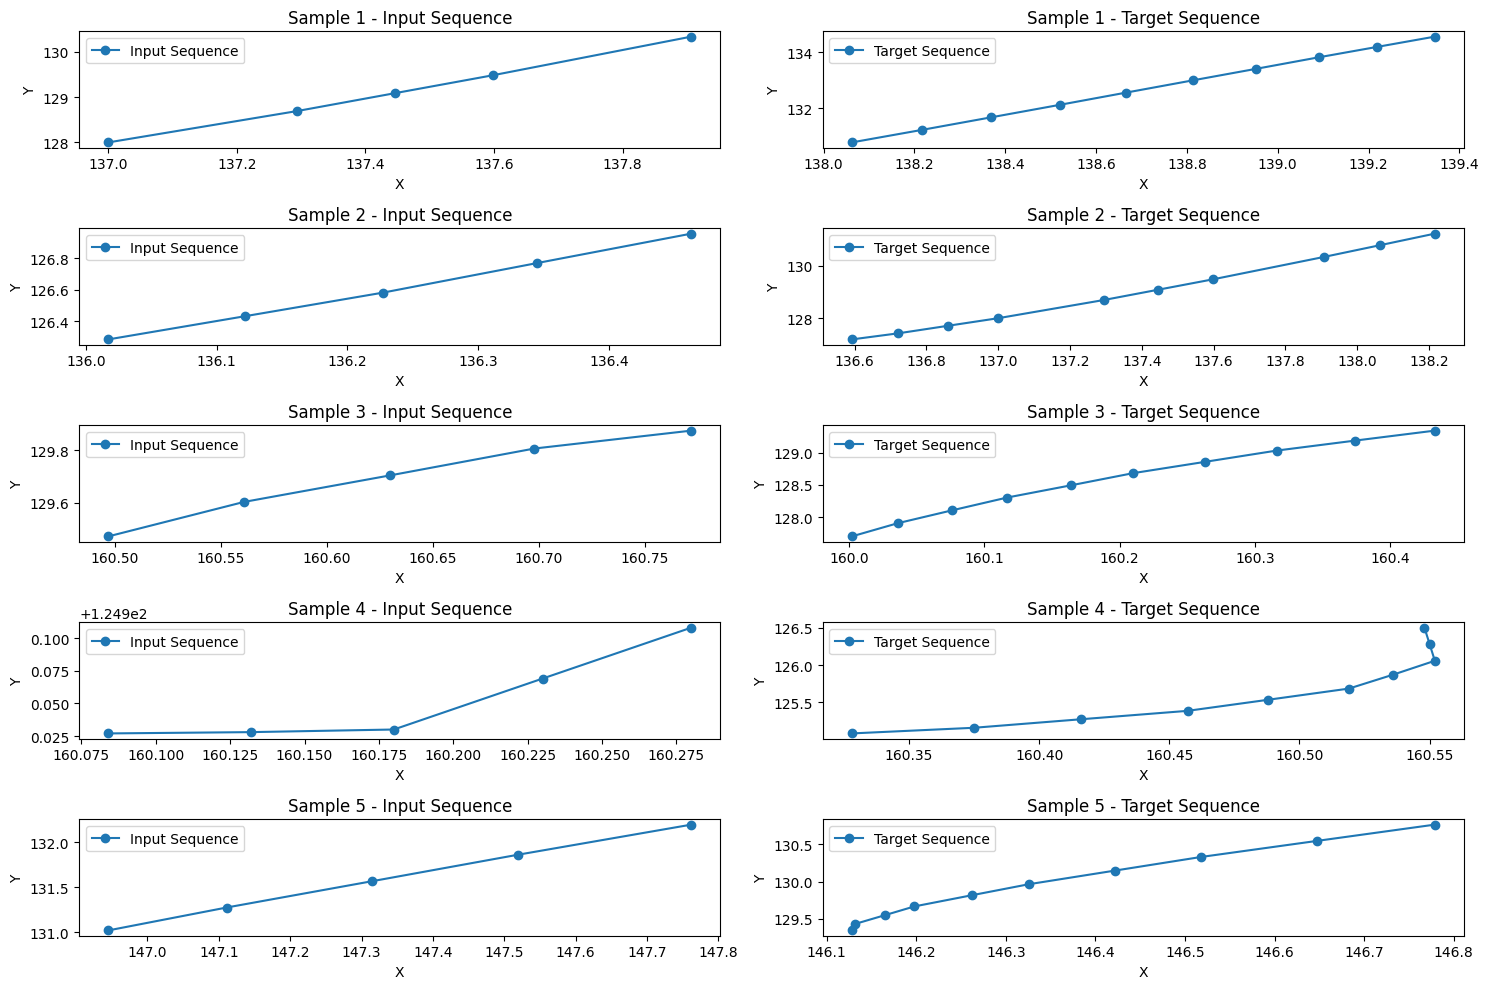

In [61]:
import matplotlib.pyplot as plt

def plot_samples(X1, y, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        input_seq = X1[i+200]
        target_seq = y[i+200]
        
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.plot(input_seq[:, 0], input_seq[:, 1], marker='o', label='Input Sequence')
        plt.title(f'Sample {i+1} - Input Sequence')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.plot(target_seq[:, 0], target_seq[:, 1], marker='o', label='Target Sequence')
        plt.title(f'Sample {i+1} - Target Sequence')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot some samples
plot_samples(X1, y)


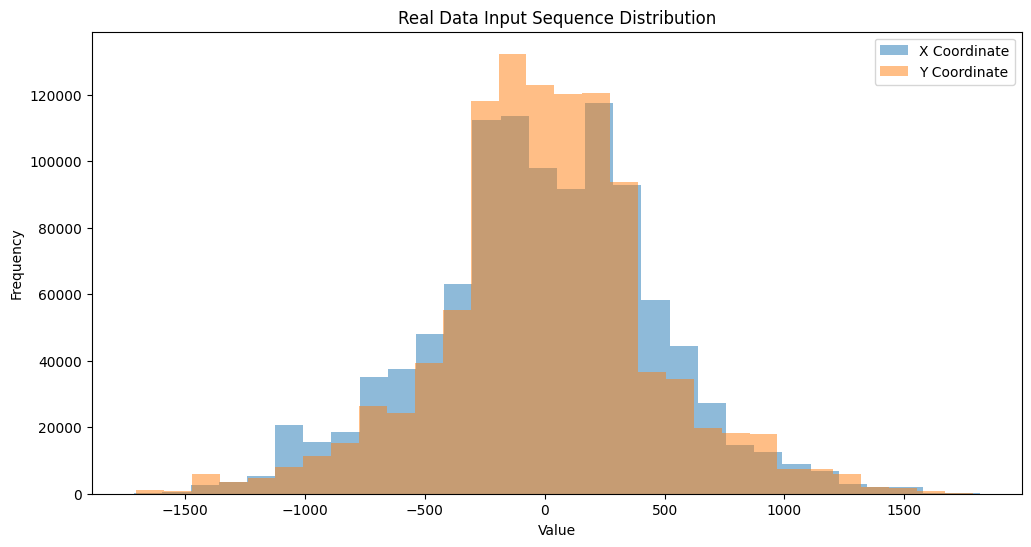

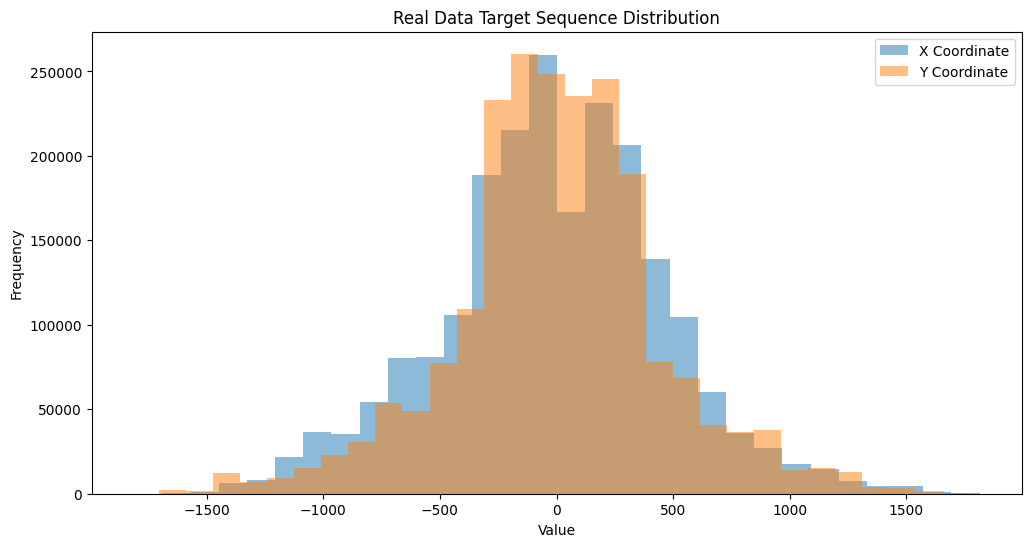

In [50]:
def plot_feature_distribution(data, title):
    plt.figure(figsize=(12, 6))
    plt.hist(data[:, :, 0].flatten(), bins=30, alpha=0.5, label='X Coordinate')
    plt.hist(data[:, :, 1].flatten(), bins=30, alpha=0.5, label='Y Coordinate')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot distributions for real data
plot_feature_distribution(X1, 'Real Data Input Sequence Distribution')
plot_feature_distribution(y, 'Real Data Target Sequence Distribution')

In [73]:
from scipy.stats import zscore

Any NaNs in X1: False
Any NaNs in y: False
Number of outliers in X1: 25487
Number of outliers in y: 22854
Outlier in X1 found at sequence index 136014, feature index 0
Outlier in y found at sequence index 136014, feature index 0


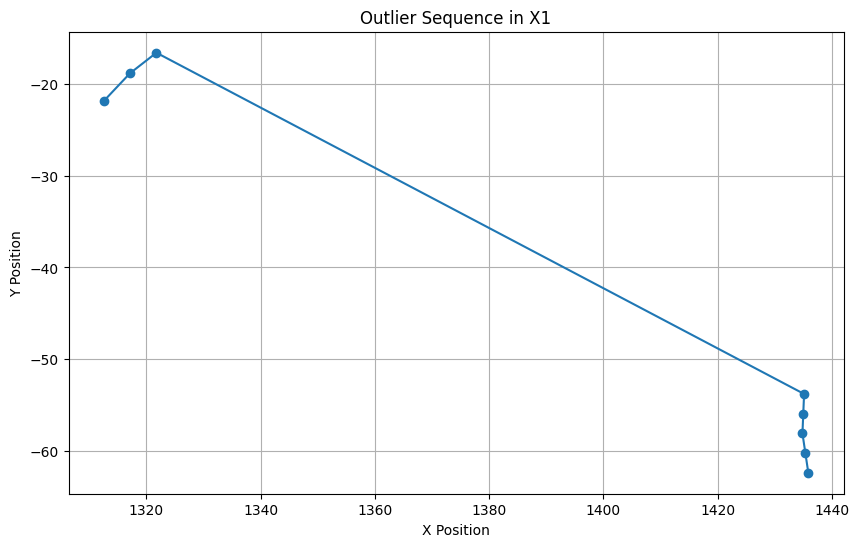

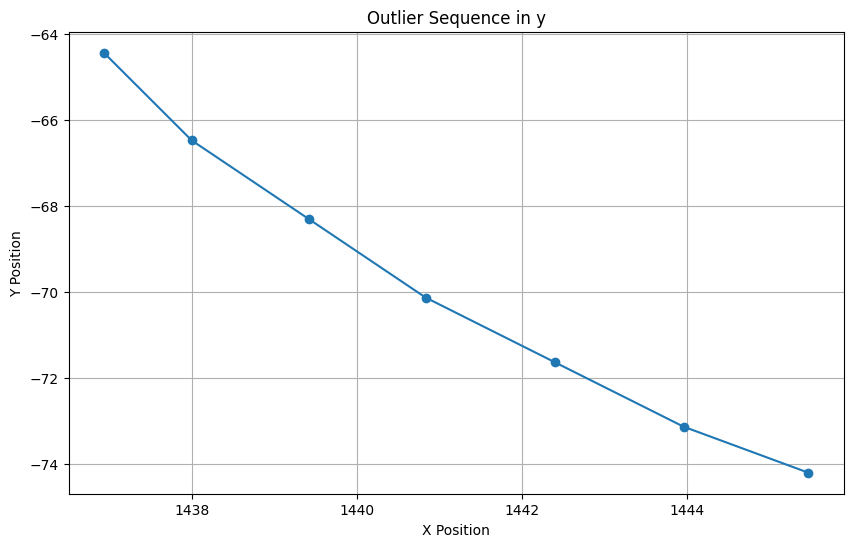

In [77]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

def detect_outliers(data):
    z_scores = np.abs(zscore(data.reshape(-1, data.shape[-1]), axis=0))
    outliers = np.where(z_scores > 3)
    return outliers

def get_outlier_sequence(data, outliers):
    sequence_length = data.shape[1]
    feature_index = outliers[1][0]
    sequence_index = outliers[0][0] // sequence_length  # Find the sequence index of the first outlier
    return data[sequence_index], sequence_index, feature_index

def plot_sequence(sequence, title):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence[:, 0], sequence[:, 1], marker='o')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.show()

# Check for NaNs
print(f'Any NaNs in X1: {np.any(np.isnan(X1))}')
print(f'Any NaNs in y: {np.any(np.isnan(y))}')

# Detect outliers
outliers_X1 = detect_outliers(X1)
outliers_y = detect_outliers(y)

print(f'Number of outliers in X1: {len(outliers_X1[0])}')
print(f'Number of outliers in y: {len(outliers_y[0])}')

# Get and plot outlier sequences
outlier_sequence_X1, seq_index_X1, feature_index_X1 = get_outlier_sequence(X1, outliers_X1)
outlier_sequence_y, seq_index_y, feature_index_y = get_outlier_sequence(y, outliers_y)

print(f"Outlier in X1 found at sequence index {seq_index_X1}, feature index {feature_index_X1}")
print(f"Outlier in y found at sequence index {seq_index_y}, feature index {feature_index_y}")

plot_sequence(outlier_sequence_X1, 'Outlier Sequence in X1')
plot_sequence(outlier_sequence_y, 'Outlier Sequence in y')


In [79]:
def prepare_data_2d(dataset, history_steps, predict_steps):
    X1_list, y_list = [], []
    for batch_x1, _ in dataset:
        batch_x1 = batch_x1.numpy()  # Convert Tensor to NumPy array
        batch_size = batch_x1.shape[0]
        for i in range(batch_size):
            sequence = batch_x1[i]
            
            # Take only the first two dimensions (2D positions)
            sequence = sequence[:, :2]  # Ensure sequence has only 2 features
            
            if len(sequence) >= history_steps + predict_steps:
                input_seq = sequence[:history_steps]
                target_seq = sequence[history_steps:history_steps + predict_steps]
                X1_list.append(input_seq)
                y_list.append(target_seq)
    
    X1 = np.array(X1_list)
    y = np.array(y_list)
    
    return X1, y

# Prepare the data
history_steps = 5
predict_steps = 10
X1, y = prepare_data_2d(loaded, history_steps, predict_steps)
print(f"Shape of X1: {X1.shape}")  # Should be (num_samples, history_steps, 2)
print(f"Shape of y: {y.shape}")    # Should be (num_samples, predict_steps, 2)


Shape of X1: (211456, 5, 2)
Shape of y: (211456, 10, 2)


Any NaNs in full sequences: False
Number of outliers in full sequences: 48304


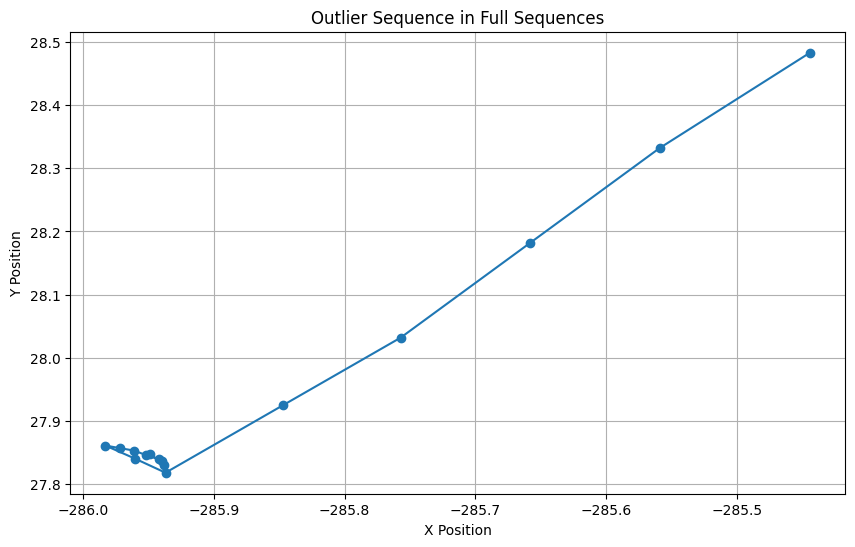

Velocity anomalies at indices: []
Acceleration anomalies at indices: []
Angle anomalies at indices: [0 6 8]


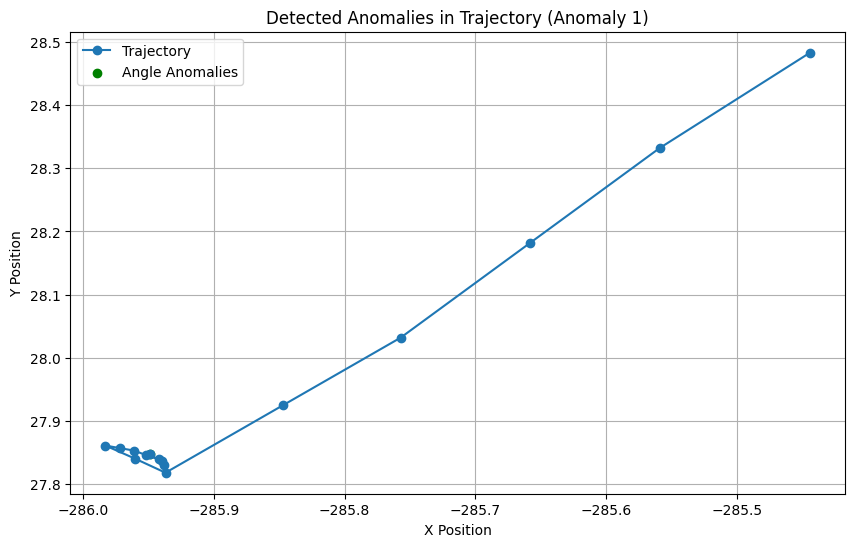

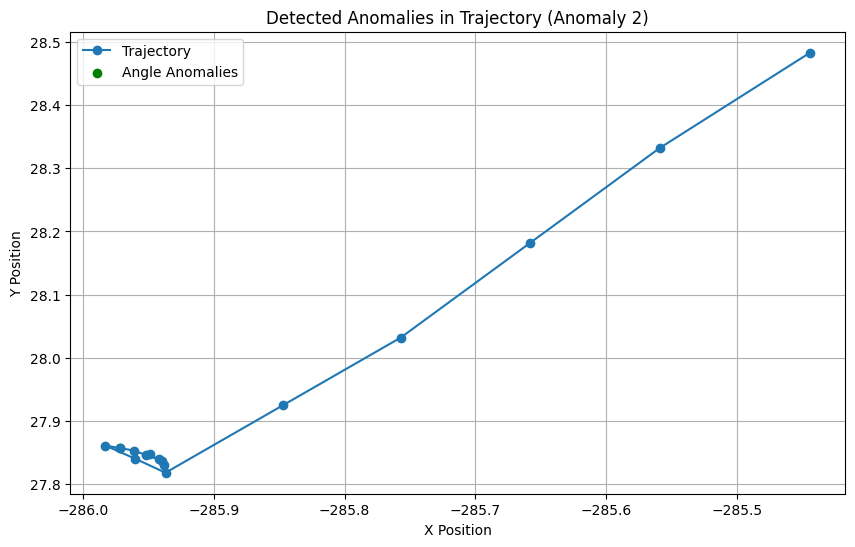

In [83]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

def detect_outliers(data):
    z_scores = np.abs(zscore(data.reshape(-1, data.shape[-1]), axis=0))
    outliers = np.where(z_scores > 3)
    return outliers

def get_outlier_sequence(data, outliers):
    index = outliers[0][0] // data.shape[-1]  # Find the flattened index
    sequence_index = index // data.shape[1]  # Find the sequence index
    return data[sequence_index], sequence_index

def plot_sequence(sequence, title):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence[:, 0], sequence[:, 1], marker='o')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.show()

def calculate_velocity(sequence):
    velocity = np.diff(sequence, axis=0)
    return velocity

def calculate_acceleration(velocity):
    acceleration = np.diff(velocity, axis=0)
    return acceleration

def calculate_angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (mag_v1 * mag_v2))
    return np.degrees(angle)

def calculate_angular_changes(velocity):
    angles = []
    for i in range(1, len(velocity)):
        angle = calculate_angle_between_vectors(velocity[i-1], velocity[i])
        angles.append(angle)
    return np.array(angles)

def detect_anomalies(velocity, acceleration, angles, velocity_threshold, acceleration_threshold, angle_threshold):
    velocity_anomalies = np.where(np.linalg.norm(velocity, axis=1) > velocity_threshold)[0]
    acceleration_anomalies = np.where(np.linalg.norm(acceleration, axis=1) > acceleration_threshold)[0]
    angle_anomalies = np.where(angles > angle_threshold)[0]
    
    return velocity_anomalies, acceleration_anomalies, angle_anomalies

def plot_anomalies(sequence, velocity_anomalies, acceleration_anomalies, angle_anomalies, anomaly_index):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence[:, 0], sequence[:, 1], marker='o', label='Trajectory')
    if anomaly_index < len(velocity_anomalies):
        plt.scatter(sequence[velocity_anomalies[anomaly_index], 0], sequence[velocity_anomalies[anomaly_index], 1], color='red', label='Velocity Anomalies')
    if anomaly_index < len(acceleration_anomalies):
        plt.scatter(sequence[acceleration_anomalies[anomaly_index], 0], sequence[acceleration_anomalies[anomaly_index], 1], color='blue', label='Acceleration Anomalies')
    if anomaly_index < len(angle_anomalies):
        plt.scatter(sequence[angle_anomalies[anomaly_index], 0], sequence[angle_anomalies[anomaly_index], 1], color='green', label='Angle Anomalies')
    plt.title(f"Detected Anomalies in Trajectory (Anomaly {anomaly_index + 1})")
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare the full sequences by combining X1 and y
full_sequences = np.concatenate([X1, y], axis=1)

# Check for NaNs
print(f'Any NaNs in full sequences: {np.any(np.isnan(full_sequences))}')

# Detect outliers in the full sequences
outliers_full_sequences = detect_outliers(full_sequences)

print(f'Number of outliers in full sequences: {len(outliers_full_sequences[0])}')

# Get and plot outlier sequence
outlier_sequence_full, seq_index_full = get_outlier_sequence(full_sequences, outliers_full_sequences)

plot_sequence(outlier_sequence_full, 'Outlier Sequence in Full Sequences')

# Reconstruct full sequence
full_sequence = full_sequences[seq_index_full]

# Calculate velocity, acceleration, and angular changes
velocity = calculate_velocity(full_sequence)
acceleration = calculate_acceleration(velocity)
angles = calculate_angular_changes(velocity)

# Set thresholds
velocity_threshold = 2.0  # Example value
acceleration_threshold = 1.0  # Example value
angle_threshold = 45.0  # Example value (in degrees)

# Detect anomalies
velocity_anomalies, acceleration_anomalies, angle_anomalies = detect_anomalies(
    velocity, acceleration, angles, velocity_threshold, acceleration_threshold, angle_threshold
)

print(f"Velocity anomalies at indices: {velocity_anomalies}")
print(f"Acceleration anomalies at indices: {acceleration_anomalies}")
print(f"Angle anomalies at indices: {angle_anomalies}")

# Initialize the anomaly index
anomaly_index = 0

# Function to plot the next anomaly
def plot_next_anomaly(anomaly_index):
    global velocity_anomalies, acceleration_anomalies, angle_anomalies
    plot_anomalies(full_sequence, velocity_anomalies, acceleration_anomalies, angle_anomalies, anomaly_index)

# Plot the first anomaly
plot_next_anomaly(anomaly_index)

# Example: Plot the next anomaly
anomaly_index += 1
if anomaly_index < len(velocity_anomalies) or anomaly_index < len(acceleration_anomalies) or anomaly_index < len(angle_anomalies):
    plot_next_anomaly(anomaly_index)
else:
    print("No more anomalies to plot.")


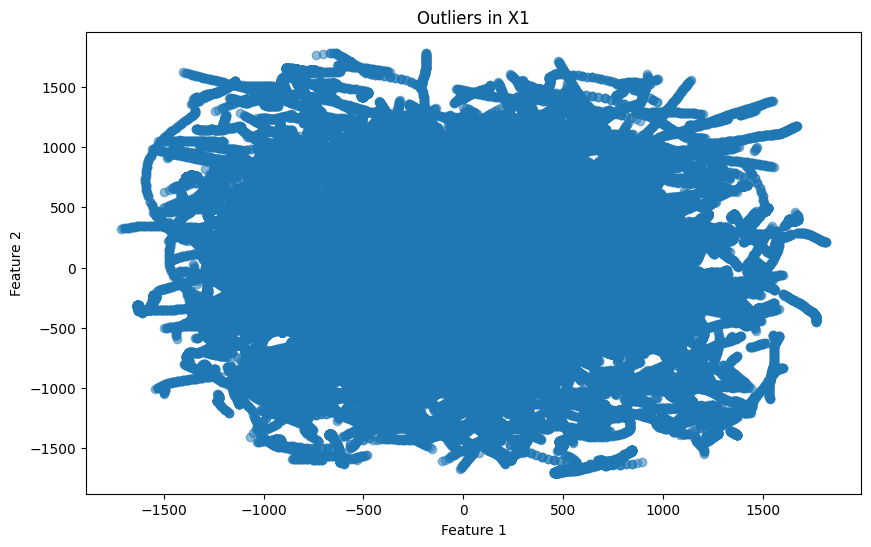

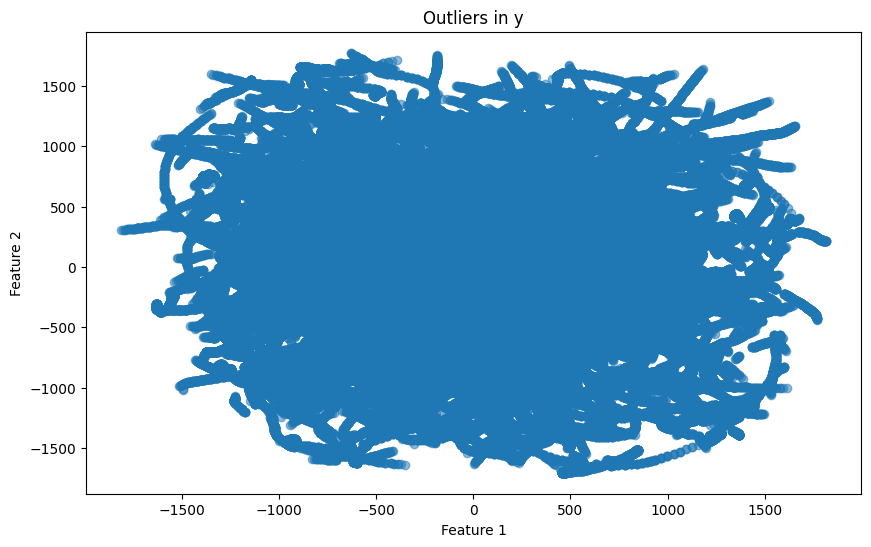

In [53]:
import matplotlib.pyplot as plt

def plot_outliers(data, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

plot_outliers(X1.reshape(-1, 2), 'Outliers in X1')
plot_outliers(y.reshape(-1, 2), 'Outliers in y')